In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage




In [72]:
class HierarchicalClustering:
    def __init__(self, filepath, k):
        self.dataset = pd.read_csv(filepath)
        self.k = k
        self.X = self.dataset[['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']].values
        self.apply_pca()
        self.X = (self.X - self.X.mean(axis=0)) / self.X.std(axis=0)

    def apply_pca(self):
        covariance_matrix = np.cov(self.X, rowvar=False)
        self.eigenvalues, self.eigenvectors = np.linalg.eig(covariance_matrix)
        sorted_indices = np.argsort(self.eigenvalues)[::-1]
        self.eigenvalues = self.eigenvalues[sorted_indices]
        self.eigenvectors = self.eigenvectors[:, sorted_indices]
        total_variance = np.sum(self.eigenvalues)
        variance_ratio = self.eigenvalues / total_variance
        cumulative_variance = np.cumsum(variance_ratio)
        self.n_components = np.argmax(cumulative_variance >= 0.95) + 1
        self.eigenvectors = self.eigenvectors[:, :self.n_components]
        self.X = np.dot(self.X, self.eigenvectors)

    def calculate_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))

    def compute_distance_matrix(self):
        num_points = len(self.X)
        distance_matrix = np.zeros((num_points, num_points))
        for i in range(num_points):
            for j in range(i + 1, num_points):
                dist = self.calculate_distance(self.X[i], self.X[j])
                distance_matrix[i][j] = dist
                distance_matrix[j][i] = dist
        return distance_matrix

    def hierarchical_clustering(self):
        clusters = [[i] for i in range(len(self.X))]
        distance_matrix = self.compute_distance_matrix()

        while len(clusters) > self.k:
            min_dist = np.inf
            merge_pair = None
            for i in range(len(clusters)):
                for j in range(i + 1, len(clusters)):
                    dist = np.mean([distance_matrix[p1, p2] for p1 in clusters[i] for p2 in clusters[j]])
                    if dist < min_dist:
                        min_dist = dist
                        merge_pair = (i, j)

            i, j = merge_pair
            new_cluster = clusters[i] + clusters[j]
            clusters.pop(max(i, j))
            clusters.pop(min(i, j))
            clusters.append(new_cluster)

        return clusters

    def silhouette_score(self, clusters):
        silhouette_scores = []

        for cluster_index, cluster in enumerate(clusters):
            for point_index in cluster:
                point = self.X[point_index]
                intra_distances = [self.calculate_distance(point, self.X[other_point]) for other_point in cluster if other_point != point_index]
                a_i = np.mean(intra_distances) if intra_distances else 0

                nearest_distances = []
                for other_cluster_index, other_cluster in enumerate(clusters):
                    if other_cluster_index != cluster_index:
                        inter_distances = [self.calculate_distance(point, self.X[other_point]) for other_point in other_cluster]
                        nearest_distances.append(np.mean(inter_distances) if inter_distances else float('inf'))

                b_i = min(nearest_distances) if nearest_distances else 0
                s_i = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) != 0 else 0
                silhouette_scores.append(s_i)

        return np.mean(silhouette_scores)

    def plot_clusters(self, clusters):
        plt.figure(figsize=(8, 6))
        colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
        for cluster_index, cluster in enumerate(clusters):
            cluster_points = self.X[cluster]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                        color=colors[cluster_index % len(colors)], 
                        label=f'Cluster {cluster_index + 1}')
        
        plt.title('Hierarchical Clustering - Cluster Scatter Plot')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend()
        plt.grid(True)
        plt.show()
   

    def plot_dendrogram(self):
        plt.figure(figsize=(10, 7))
        Z = linkage(self.X, method='single')
        dendrogram(Z)
        plt.title('Hierarchical Clustering - Dendrogram')
        plt.xlabel('Data Points')
        plt.ylabel('Distance')
        plt.grid(True)
        plt.show()



Silhouette Score for k=2: 0.8013974107924106


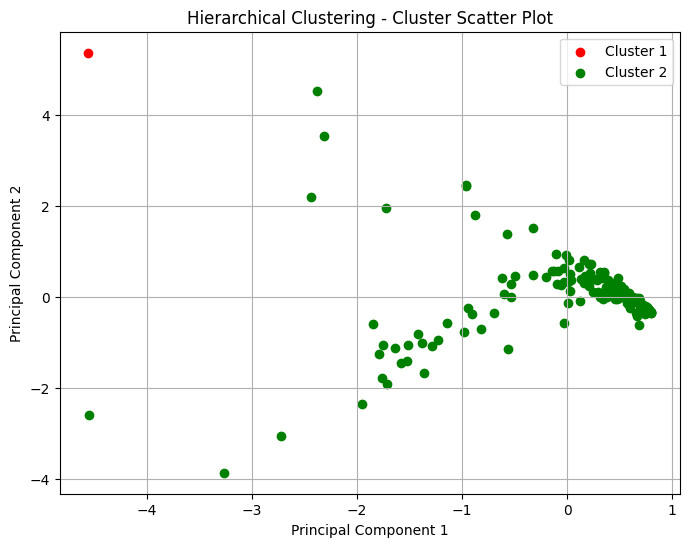

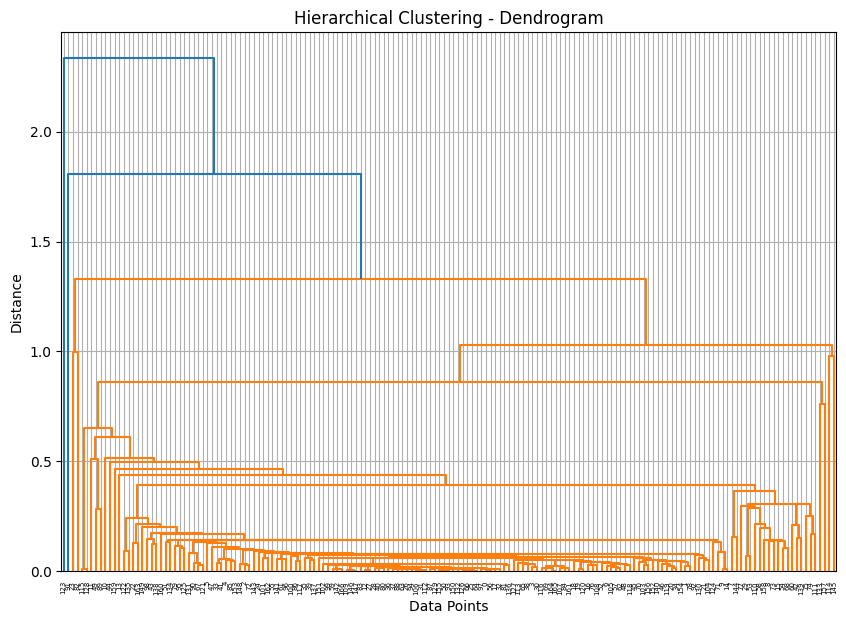

In [73]:
if __name__ == "__main__":
    filepath = r"C:\Users\pkmna\Downloads\data.csv"
    k = 2
    hierarchical = HierarchicalClustering(filepath, k)
    clusters = hierarchical.hierarchical_clustering()

    
    score = hierarchical.silhouette_score(clusters)
    print(f"Silhouette Score for k={k}: {score}")

    
    hierarchical.plot_clusters(clusters)
    hierarchical.plot_dendrogram()